In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

C:\Users\rayan\AppData\Local\Temp\ipykernel_18112\2916246244.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
all_data = pd.read_csv("../previsão-de-votação-de-deputados/eleicoes_2006_a_2010.csv")

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    7330 non-null   int64  
 1   sequencial_candidato                   7330 non-null   int64  
 2   nome                                   7330 non-null   object 
 3   uf                                     7330 non-null   object 
 4   partido                                7330 non-null   object 
 5   quantidade_doacoes                     7330 non-null   int64  
 6   quantidade_doadores                    7330 non-null   int64  
 7   total_receita                          7169 non-null   float64
 8   media_receita                          7169 non-null   float64
 9   recursos_de_outros_candidatos/comites  4940 non-null   float64
 10  recursos_de_pessoas_fisicas            4647 non-null   float64
 11  recu

In [4]:
all_data.describe(include=['object'])

,nome,uf,partido,cargo,sexo,grau,estado_civil,ocupacao
count,7330,7330,7330,7330,7330,7330,7330,7330
unique,6775,27,31,1,2,7,5,175
top,LUIZ CARLOS GOMES,SP,PT,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),OUTROS
freq,3,1623,606,7330,6305,4255,4704,819


In [5]:
all_data.votos.isnull().sum()

0

In [6]:
train = all_data.query('ano == 2006')
test = all_data.query('ano == 2010')

In [7]:
train.head(5)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [8]:
test.head(5)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
3388,2010,10000000194,ANTONIA LUCILEIA CRUZ RAMOS CAMARA,AC,PSC,36,35,406891.92,11625.483429,269179.61,...,54,48,381881.55,7955.865625,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),EMPRESÁRIO,15849
3389,2010,10000000195,DEODATO NUNES DE FRANÇA,AC,PMDB,3,3,6990.00,2330.000000,NaN,...,3,3,6990.00,2330.000000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),OUTROS,4620
3390,2010,10000000196,EDSON FIRMINO DE PAULA,AC,PSDB,3,3,1840.00,613.333333,290.00,...,3,3,1840.00,613.333333,DEPUTADO FEDERAL,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),"OPERADOR DE EQUIPAMENTO DE RÁDIO, TELEVISÃO, S...",312
3391,2010,10000000197,ELISABETH APARECIDA GARCIA RODRIGUES,AC,PSDB,1,1,440.00,440.000000,440.00,...,1,1,440.00,440.000000,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),PROFESSOR DE ENSINO MÉDIO,1357
3392,2010,10000000198,FLAVIANO FLAVIO BAPTISTA DE MELO,AC,PMDB,15,13,241500.00,18576.923077,NaN,...,83,59,232677.64,3943.688814,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),DEPUTADO,36301


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3388 entries, 0 to 3387
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    3388 non-null   int64  
 1   sequencial_candidato                   3388 non-null   int64  
 2   nome                                   3388 non-null   object 
 3   uf                                     3388 non-null   object 
 4   partido                                3388 non-null   object 
 5   quantidade_doacoes                     3388 non-null   int64  
 6   quantidade_doadores                    3388 non-null   int64  
 7   total_receita                          3227 non-null   float64
 8   media_receita                          3227 non-null   float64
 9   recursos_de_outros_candidatos/comites  1879 non-null   float64
 10  recursos_de_pessoas_fisicas            2144 non-null   float64
 11  recu

Determinando números máximos de cada coluna

In [10]:
train.max()

ano                                                     2006
sequencial_candidato                                   13433
nome                                      ÍRIS XAVIER SIMÕES
uf                                                        TO
partido                                                   PV
quantidade_doacoes                                       639
quantidade_doadores                                      595
total_receita                                     2620860.21
media_receita                                  129111.111111
recursos_de_outros_candidatos/comites               672000.0
recursos_de_pessoas_fisicas                        1381000.0
recursos_de_pessoas_juridicas                      2324000.0
recursos_proprios                                  2638000.0
quantidade_despesas                                     5545
quantidade_fornecedores                                 3384
total_despesa                                      2684085.1
media_despesa           

Determinando números mínimos de cada coluna

In [11]:
train.min()

ano                                                             2006
sequencial_candidato                                           10001
nome                                          ABDELAZIZ ABOUD SANTOS
uf                                                                AC
partido                                                          PAN
quantidade_doacoes                                                 1
quantidade_doadores                                                1
total_receita                                                    0.0
media_receita                                                    0.0
recursos_de_outros_candidatos/comites                           2.41
recursos_de_pessoas_fisicas                                     0.03
recursos_de_pessoas_juridicas                                    0.0
recursos_proprios                                                0.0
quantidade_despesas                                                1
quantidade_fornecedores           

Normalizando o modelos

In [12]:
from sklearn.preprocessing import StandardScaler
normalizador = StandardScaler()

In [13]:
train[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']] = normalizador.fit_transform(train[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita','media_receita','recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']])

C:\Users\rayan\AppData\Local\Temp\ipykernel_18112\3659544205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']] = normalizador.fit_transform(train[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita','media_receita','recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_d

In [14]:
test[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']] = normalizador.fit_transform(test[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita','media_receita','recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']])

C:\Users\rayan\AppData\Local\Temp\ipykernel_18112\1967753550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_despesa','media_despesa','votos']] = normalizador.fit_transform(test[['ano','sequencial_candidato','quantidade_doacoes','quantidade_doadores','total_receita','media_receita','recursos_de_outros_candidatos/comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_despesas','quantidade_fornecedores','total_des

In [15]:
train.head(5)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,0.0,-1.020598,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,-0.373082,-0.362606,-0.346097,-0.180090,NaN,...,-0.324080,-0.328781,-0.368529,0.047723,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,-0.319929
1,0.0,-1.019252,LOIVA DE OLIVEIRA,RO,PT,-0.218212,-0.195783,-0.318807,-0.295411,-0.156915,...,-0.287864,-0.287349,-0.352856,-0.125743,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,-0.447279
2,0.0,-1.019252,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,-0.129715,-0.124287,0.230396,0.560433,-0.250351,...,0.070675,0.103947,0.173526,0.144268,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,-0.126367
3,0.0,-1.019252,ROMALDO MILANI,MS,PRONA,-0.373082,-0.362606,-0.405705,-0.438665,NaN,...,-0.345810,-0.356402,-0.425414,-0.419039,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,-0.481490
4,0.0,-1.017906,ANSELMO DE JESUS ABREU,RO,PT,0.556136,0.638332,NaN,NaN,NaN,...,0.106891,0.159188,0.049579,-0.075918,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,0.135530


array([[<AxesSubplot:title={'center':'votos'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

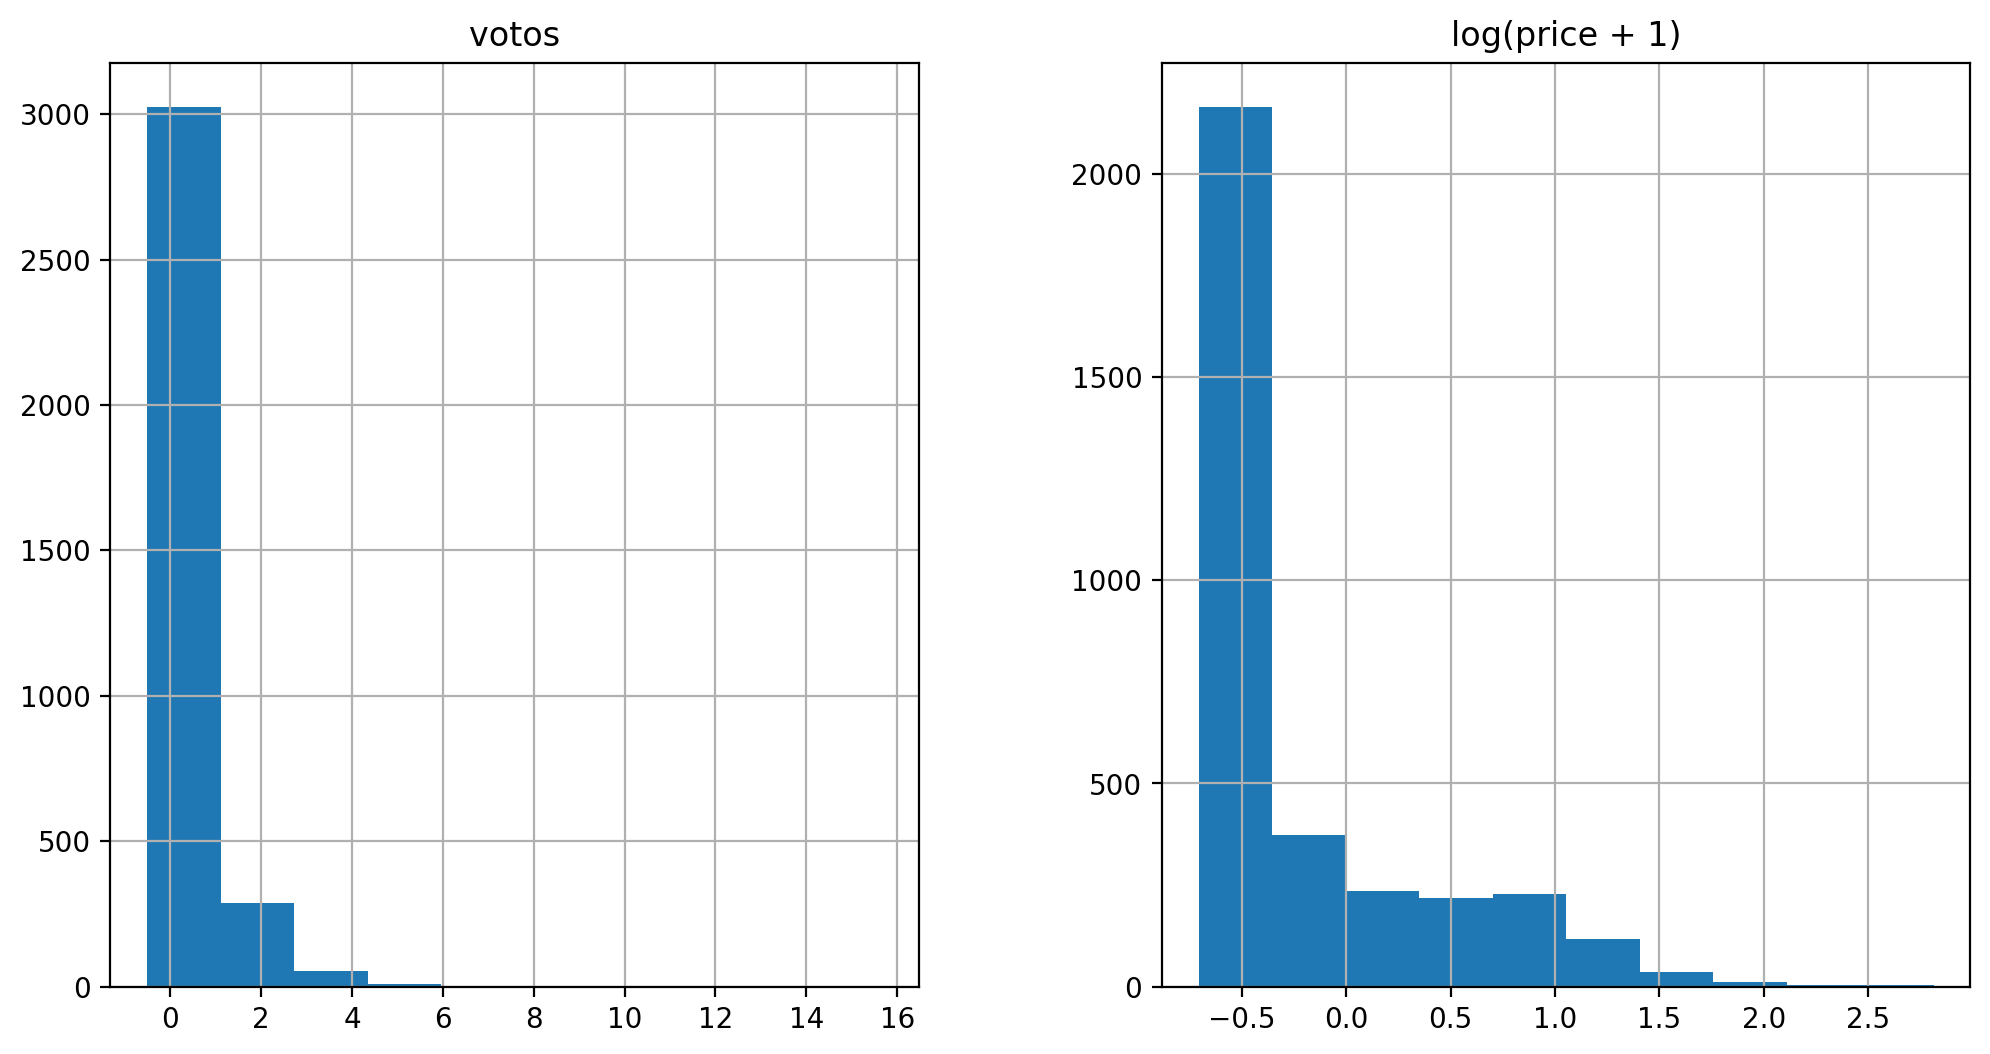

In [16]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
votos = pd.DataFrame({"votos":train["votos"], "log(price + 1)":np.log1p(train["votos"])})
votos.hist()

In [17]:
#log transform the target:
train["votos"] = np.log1p(train["votos"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

C:\Users\rayan\AppData\Local\Temp\ipykernel_18112\3077676299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["votos"] = np.log1p(train["votos"])


In [18]:
all_data = pd.get_dummies(all_data)

In [19]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [20]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

## Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [21]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [22]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [23]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

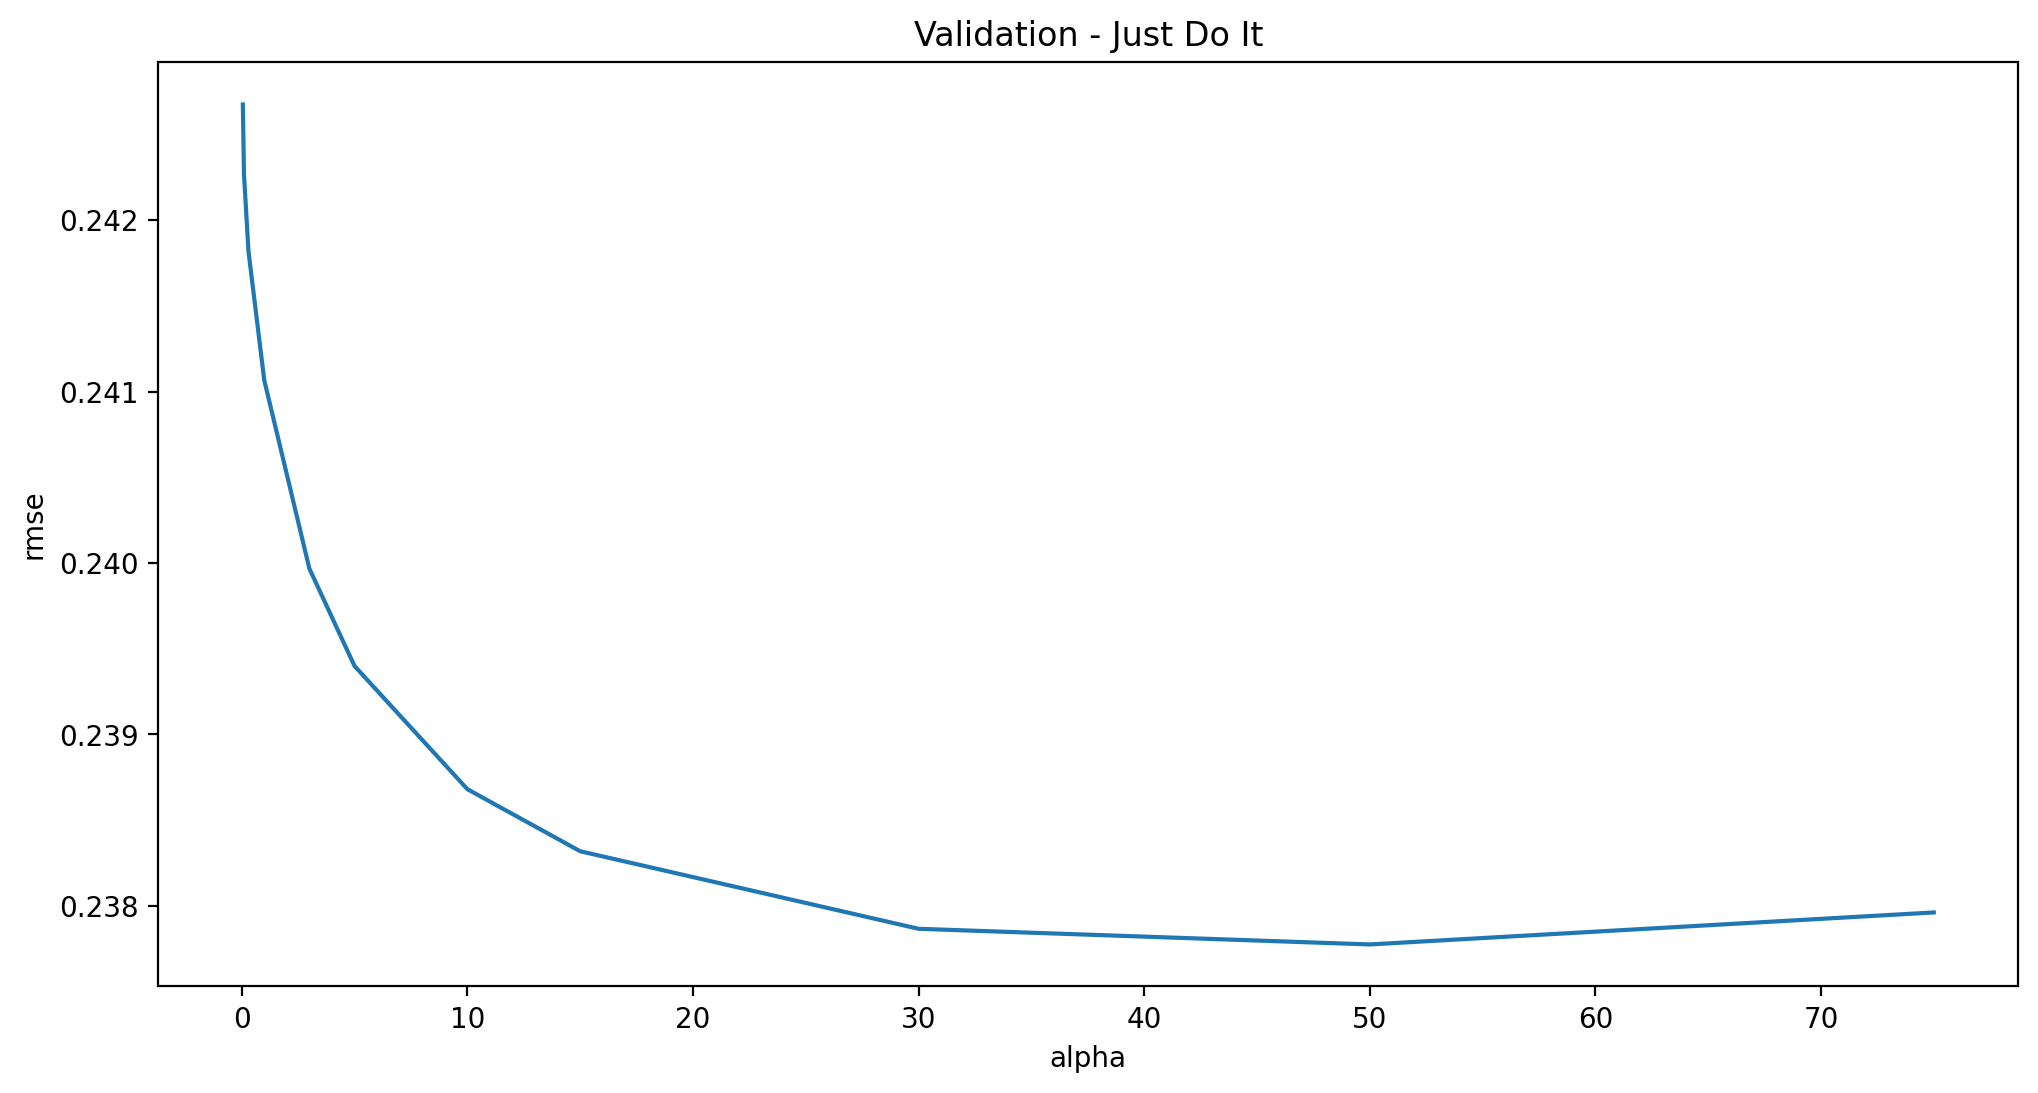

In [24]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [25]:
cv_ridge.min()

0.23777384339513744

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [26]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e+00, tolerance: 9.790e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+00, tolerance: 9.790e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [27]:
rmse_cv(model_lasso).mean()

c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+00, tolerance: 7.405e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e+00, tolerance: 7.405e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

0.23523294853880233

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [28]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [29]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 56 variables and eliminated the other 6982 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [30]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

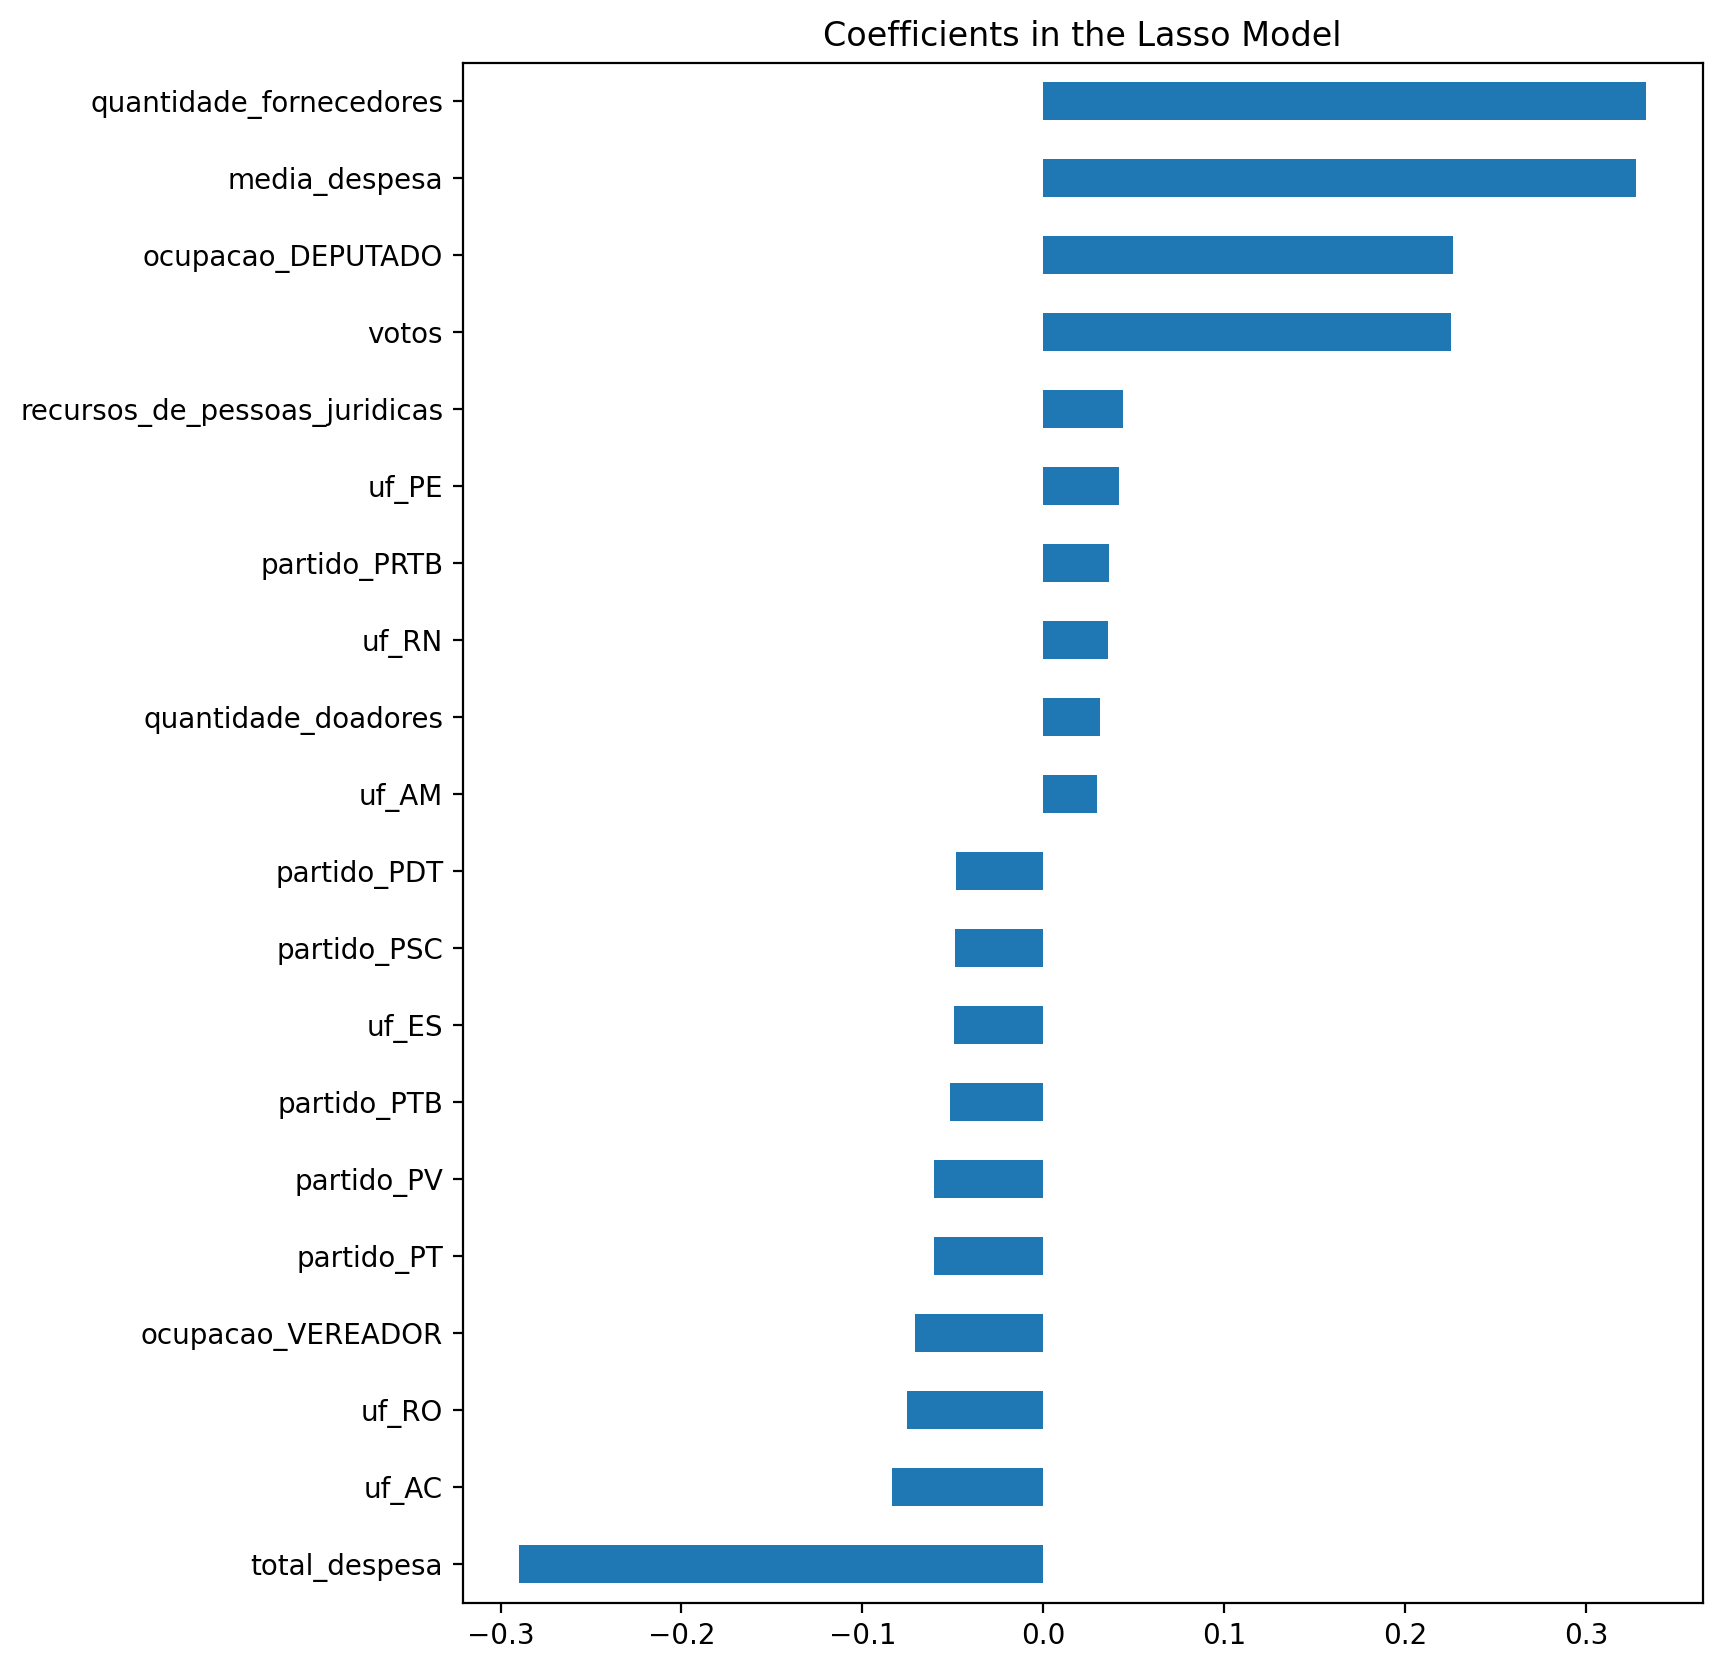

In [31]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

<AxesSubplot:xlabel='preds', ylabel='residuals'>

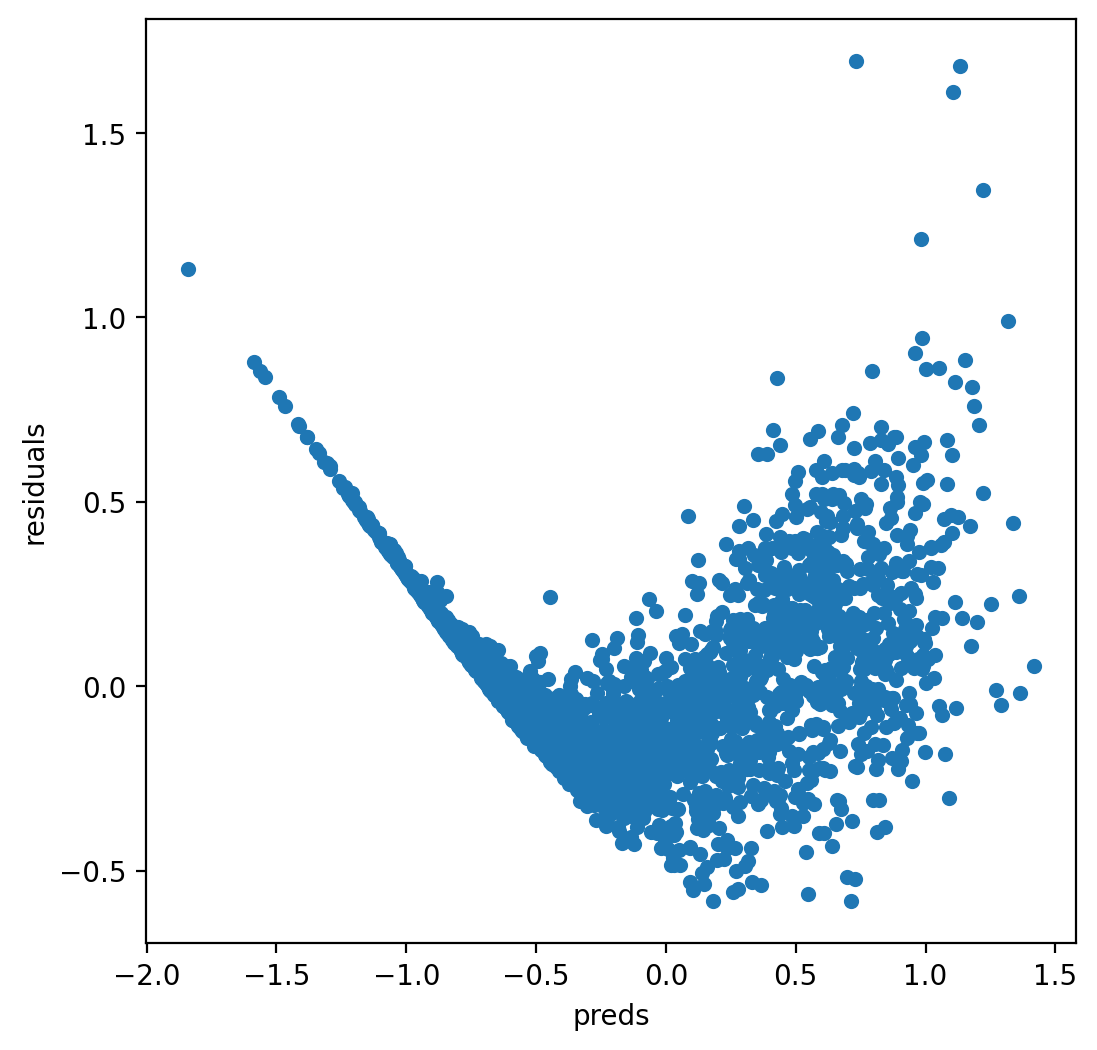

In [32]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

## Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [33]:
import xgboost as xgb

In [34]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

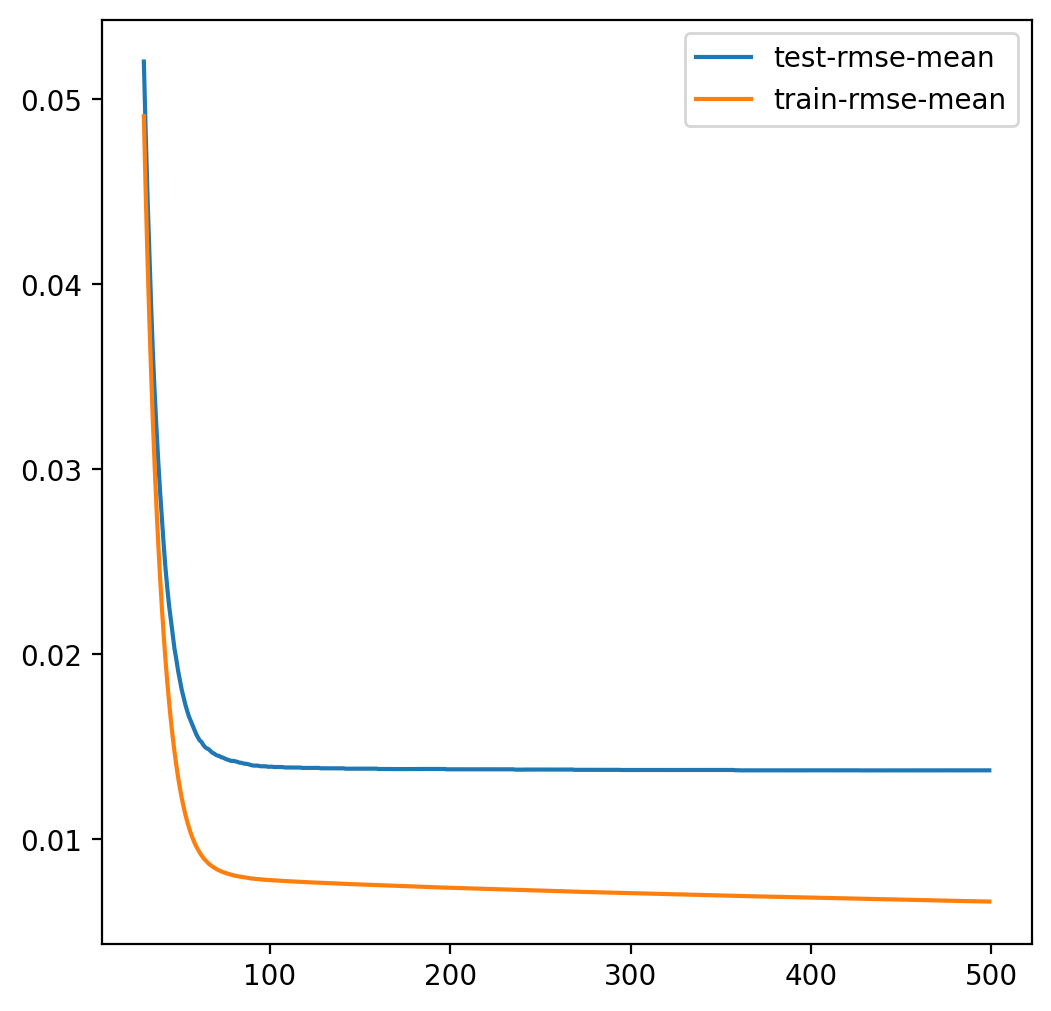

In [35]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [36]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=360, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

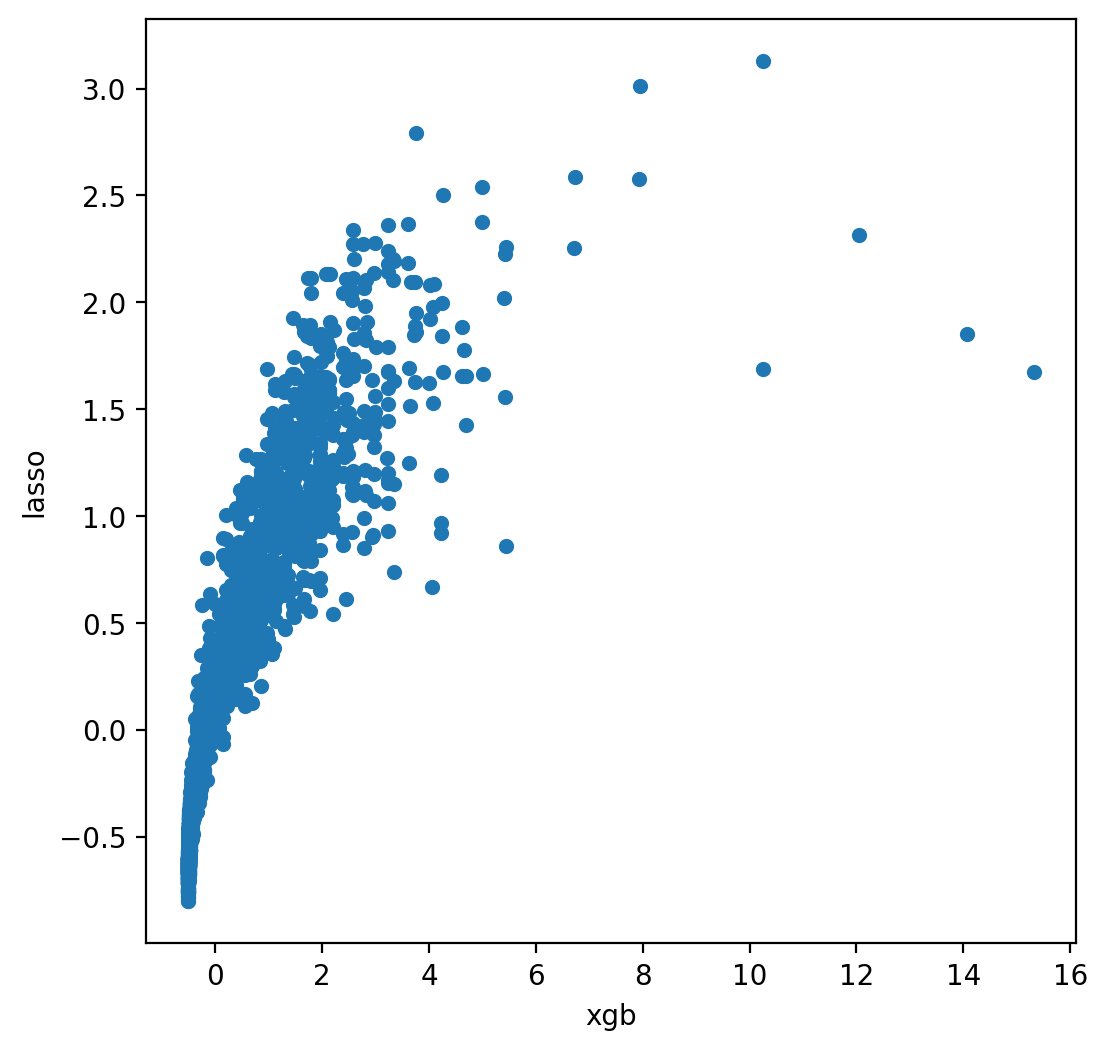

In [38]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [39]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [40]:
solution = pd.DataFrame({"id":test.ano, "votos":preds})
solution.to_csv("ridge_sol.csv", index = False)

## Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [41]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [42]:
X_train = StandardScaler().fit_transform(X_train)

In [43]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [44]:
X_tr.shape

(2541, 7038)

## KNN

In [121]:
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.plotting import plot_decision_regions

In [122]:
all_data['votos'] = pd.to_numeric(all_data['votos'])
dummies = pd.get_dummies(all_data)
x = np.array(dummies.drop(['votos'], 1))
y = np.array(dummies['votos'])

C:\Users\rayan\AppData\Local\Temp\ipykernel_18112\3647043356.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = np.array(dummies.drop(['votos'], 1))


In [123]:
from sklearn import model_selection

x_train_knn, x_test_knn, y_train_knn, y_test_knn = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

In [124]:
normalizacao_knn = StandardScaler()
x_train_knn = normalizacao_knn.fit_transform(x_train_knn)
x_test_knn = normalizacao_knn.fit_transform(x_test_knn)

In [125]:
from sklearn import neighbors

model_clf = neighbors.KNeighborsRegressor(n_neighbors=80, metric='euclidean')

In [126]:
model_clf.fit(x_train_knn, y_train_knn)

KNeighborsRegressor(metric='euclidean', n_neighbors=80)

In [127]:
accuracy = model_clf.score(x_test_knn, y_test_knn)
accuracy

0.040085335730647875

In [130]:
def knn_comparison(all_data, k):
    x = all_data[['sequencial_candidato','ano']].values
    y = all_data['votos'].astype(int).values
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(x, y)
    plot_decision_regions(x, y, clf=knn)
    plt.xlabel('ssc_p')
    plt.ylabel('hsc_p')
    plt.title('K='+ str(k))
    plt.show()

In [ ]:
knn_comparison(all_data=dummies, k=80)